## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import AUC, Precision, Recall
import pydot
import time
import logging

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
37935,00009972_000.png,Mass,0,9972,64,M,PA,2500,2048,0.168,0.168,NaN,/data/images_005/images/00009972_000.png
29339,00007632_004.png,Infiltration,4,7632,53,F,PA,2544,3056,0.139,0.139,NaN,/data/images_004/images/00007632_004.png
97191,00025635_008.png,Effusion|Mass|Nodule,8,25635,43,F,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00025635_008.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
22847,00006039_009.png,Atelectasis|Effusion,9,6039,59,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89536,00022235_010.png,Mass,10,22235,46,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
42518,00010939_000.png,Cardiomegaly,0,10939,48,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = np.where(all_xray_df['Pneumonia'], 1, 0)
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [5]:
pneumonia_count = sum(all_xray_df['pneumonia_class']==1)
print(f'Number of pneumonia cases: {pneumonia_count} out of {len(all_xray_df)}')

Number of pneumonia cases: 1431 out of 112120


## Create your training and testing data:

### I will first work with an even number of pneumonia cases and non-pneumonia cases

In [6]:
positive = all_xray_df.loc[all_xray_df['pneumonia_class']==1]
negative = all_xray_df.loc[all_xray_df['pneumonia_class']==0].sample(len(positive))
df = positive.append(negative)
# Make the y_column be a string to avoid TypeError: If class_mode="binary", y_col="pneumonia_class" column values must be strings.
df['pneumonia_class'] = df['pneumonia_class'].astype(str)
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29296,00007624_035.png,No Finding,35,7624,25,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
44107,00011370_001.png,No Finding,1,11370,43,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
34097,00008922_019.png,No Finding,19,8922,25,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
22618,00005987_000.png,No Finding,0,5987,38,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [7]:
def create_splits(X, y, test_size):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [8]:
y = df['pneumonia_class']
X = df.drop(['pneumonia_class'],axis=1)
X_train, X_test, y_train, y_test = create_splits(X, y, .25)
train_df = X_train.join(y_train)
val_data = X_test.join(y_test)

In [9]:
print(f'X_train: {len(X_train)}\nX_test: {len(X_test)}\ny_train: {len(y_train)}\ny_test: {len(y_test)}')

X_train: 2146
X_test: 716
y_train: 2146
y_test: 716


(array([380.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 336.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

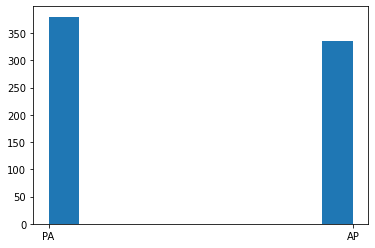

In [42]:
plt.hist(val_data['View Position'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


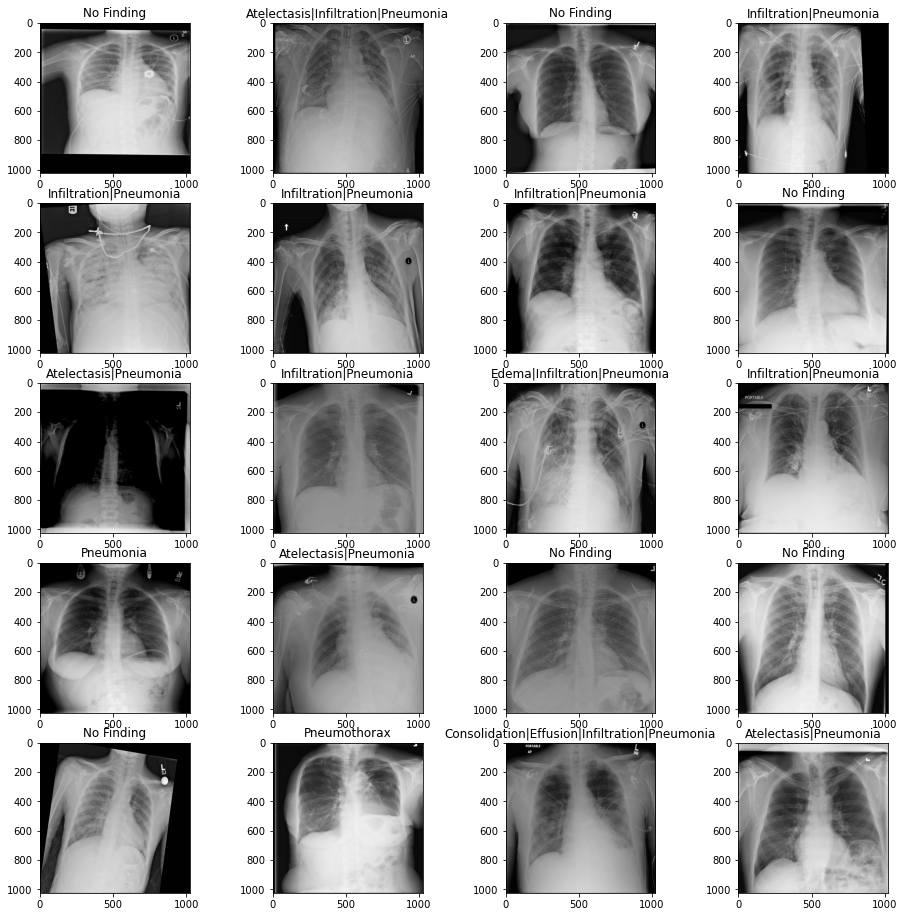

In [51]:
from skimage import io

fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = train_df['path']
ind=0
mean_intensities = []
std_intensities = []

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(train_df.iloc[ind]['Finding Labels'])
    mean_intensity = np.mean(img)
    mean_intensities.append(mean_intensity)
    std_intensity = np.std(img)
    std_intensities.append(std_intensity)
    new_img = img.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    ax.imshow(new_img,cmap='gray')
    ax.set_title(train_df.iloc[ind]['Finding Labels'])
    ind=ind+1

(array([2., 7., 2., 3., 3., 1., 1., 0., 0., 1.]),
 array([ 94.27320862, 103.27084229, 112.26847596, 121.26610963,
        130.26374331, 139.26137698, 148.25901065, 157.25664432,
        166.25427799, 175.25191166, 184.24954534]),
 <a list of 10 Patch objects>)

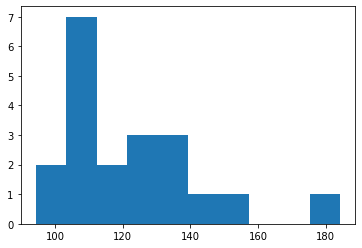

In [52]:
plt.hist(mean_intensities)

(array([2., 0., 1., 2., 2., 6., 1., 3., 2., 1.]),
 array([33.21630623, 38.08875257, 42.9611989 , 47.83364523, 52.70609157,
        57.5785379 , 62.45098424, 67.32343057, 72.19587691, 77.06832324,
        81.94076957]),
 <a list of 10 Patch objects>)

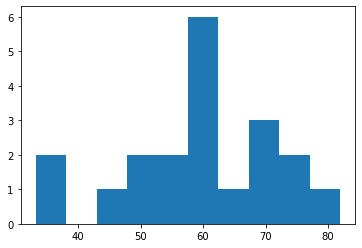

In [53]:
plt.hist(std_intensities)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [10]:
IMG_SIZE = (224, 224)

def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    return my_idg


def make_train_gen(train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
    my_train_idg = my_image_augmentation()
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 9
                                         )

    return train_gen


def make_val_gen(val_data):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 

    # Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    
    val_gen = val_idg.flow_from_dataframe(dataframe = val_data,
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = IMG_SIZE, 
                                          batch_size = 9)


    return val_gen

In [11]:
train_gen = make_train_gen(train_df)
val_gen = make_val_gen(val_data)

Found 2146 validated image filenames belonging to 2 classes.
Found 716 validated image filenames belonging to 2 classes.


In [12]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

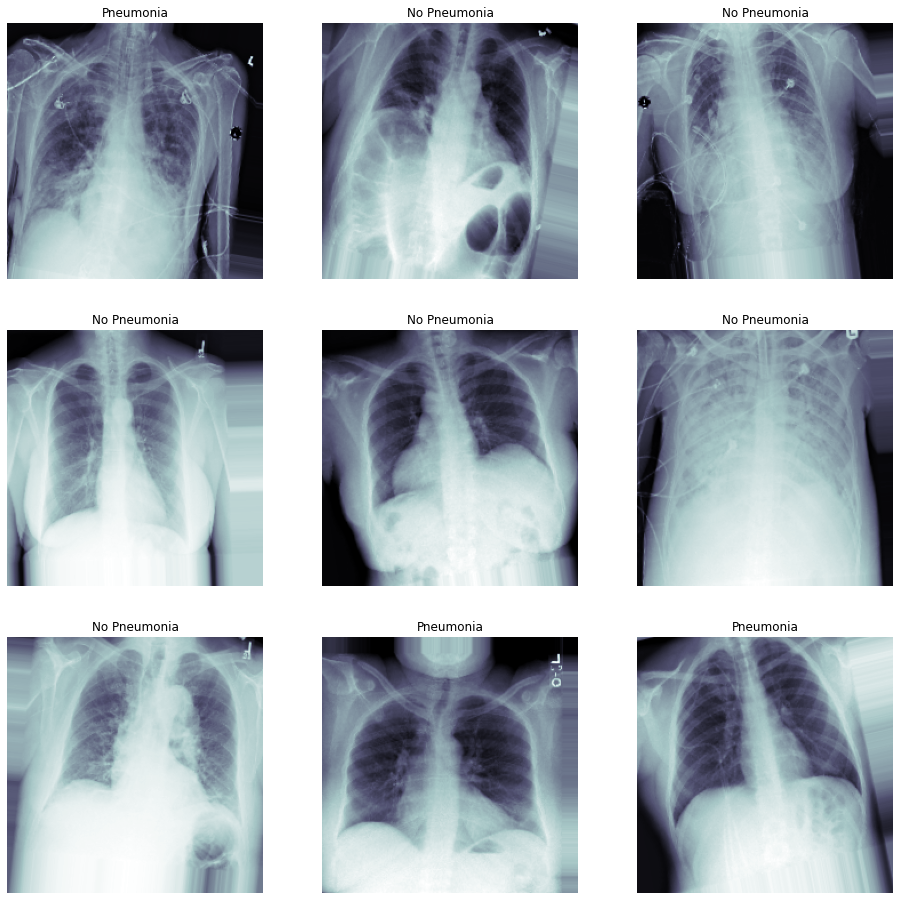

In [32]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [14]:
def load_pretrained_model(**kwargs):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    
    print(vgg_model.summary())
    
    return vgg_model


In [15]:
def build_my_model(**kwargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    print(kwargs)
    
    my_model = Sequential()
    vgg_model = load_pretrained_model()
    my_model.add(vgg_model)

    if 'layers_to_freeze' in kwargs.keys():
        layers_to_freeze = kwargs.get('layers_to_freeze')
        for layer in my_model.layers[0:layers_to_freeze]:
            layer.trainable = False
    
    if 'optimizer' in kwargs.keys():
        optimizer = kwargs.get('optimizer')
        
    if 'loss_function' in kwargs.keys():
        loss = kwargs.get('loss_function')
    
    if 'metrics' in kwargs.keys():
        metrics = kwargs.get('metrics')
    
    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
    
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [16]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

xray_class = 'pneumonia_class'
# iteration to denote different times I have run the notebook
iteration = '2'
# prefix to denote different times I have run the notebook
_time = time.localtime()
prefix = time.strftime("%m_%d_%Y_%H_%M")

weight_path="{}_{}_my_model.best.hdf5".format(xray_class, prefix)

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'binary_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'max', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'binary_accuracy', 
                      mode= 'max', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [17]:
## train your model
## When reloading the notebook, comment out this cell's contents and run the next cell to load in the saved model.

metrics = [
    'binary_accuracy',
    AUC(),
    Precision(),
    Recall()
]

kwargs = {'layers_to_freeze':16, 'optimizer': Adam(lr=1e-4), 'loss_function': 'binary_crossentropy', 'metrics': metrics}
my_model = build_my_model(**kwargs)

{'layers_to_freeze': 16, 'optimizer': <keras.optimizers.Adam object at 0x7f9e3e5c6790>, 'loss_function': 'binary_crossentropy', 'metrics': ['binary_accuracy', <tensorflow.python.keras.metrics.AUC object at 0x7f9e3e5c6350>, <tensorflow.python.keras.metrics.Precision object at 0x7f9e3bcc7350>, <tensorflow.python.keras.metrics.Recall object at 0x7f9e3e622c50>]}
553467904/553467096 [==============================] - 7s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D) 

In [18]:
## If you are reloading the notebook and do not want to rerun the training process, set run_training = False
run_training = False
if run_training:
    t_start = time.time()
    history = my_model.fit_generator(train_gen, 
                                     validation_data = (valX, valY), 
                                     epochs = 125, 
                                     callbacks = callbacks_list)
    t_finish = time.time()
    print(f'Training took {t_start - t_finish} seconds')

Epoch 1/125
239/239 [==============================] - 64s 268ms/step - loss: 0.8422 - binary_accuracy: 0.5084 - auc: 0.4934 - precision: 0.5142 - recall: 0.5460 - val_loss: 0.6537 - val_binary_accuracy: 0.8889 - val_auc: 0.5188 - val_precision: 0.5064 - val_recall: 0.5140

Epoch 00001: binary_accuracy improved from -inf to 0.50839, saving model to pneumonia_class_06_15_2020_22_38_my_model.best.hdf5
Epoch 2/125
239/239 [==============================] - 57s 239ms/step - loss: 0.7880 - binary_accuracy: 0.5093 - auc: 0.5164 - precision: 0.5109 - recall: 0.5181 - val_loss: 0.6614 - val_binary_accuracy: 0.6667 - val_auc: 0.5142 - val_precision: 0.5066 - val_recall: 0.5047

Epoch 00002: binary_accuracy improved from 0.50839 to 0.50932, saving model to pneumonia_class_06_15_2020_22_38_my_model.best.hdf5
Epoch 3/125
239/239 [==============================] - 58s 242ms/step - loss: 0.7419 - binary_accuracy: 0.5415 - auc: 0.5187 - precision: 0.5128 - recall: 0.5103 - val_loss: 0.6541 - val_bina

### The model from June 15th underwent 3658 seconds of training, reached epoch 65/125 and stopped due to earlystopping callback of ten epochs without binary_accuracy increasing. The metrics for epoch 65 were loss: 0.6336 - binary_accuracy: 0.6361 - auc: 0.6309 - precision: 0.5969 - recall: 0.5737 - val_loss: 0.6442 - val_binary_accuracy: 0.5556 - val_auc: 0.6314 - val_precision: 0.5972 - val_recall: 0.5738

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [20]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

# June 15th was the last time I ran the full training, so set that as weight path
weight_path = 'pneumonia_class_2_my_model.best.hdf5' #'pneumonia_class_06_15_2020_15_29_my_model.best.hdf5'
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

9/9 [==============================] - 6s 628ms/step


In [21]:
# function to plot the roc_curve. You can utilize roc_curve and auc imported above
def plot_roc_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

def plot_history(history):
    dot_img_file = '/tmp/model_1.png'
    plot_model(history, to_file=dot_img_file, show_shapes=True)

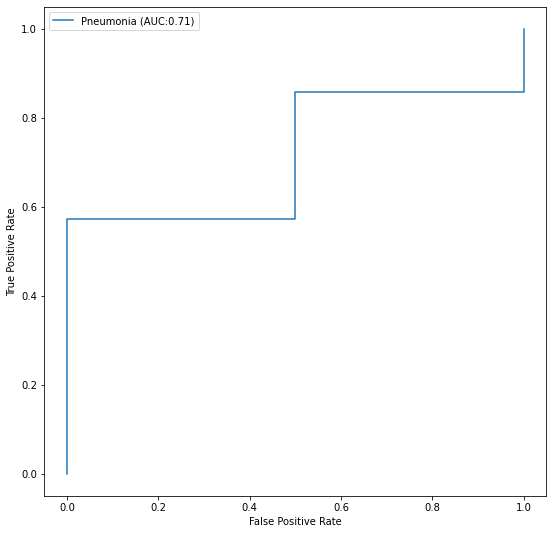

In [22]:
plot_roc_curve(valY, pred_Y)

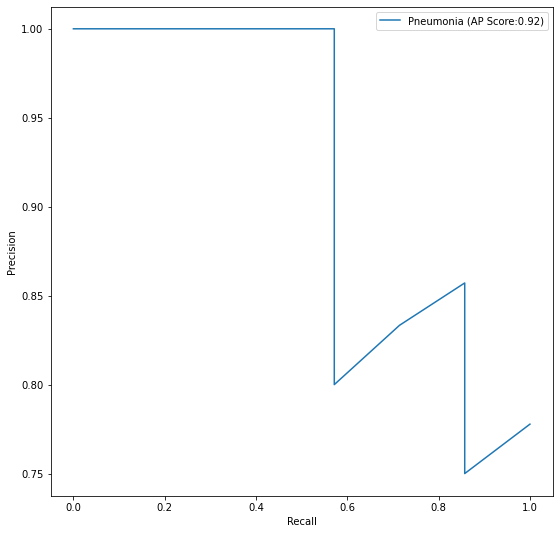

In [23]:
plot_precision_recall_curve(valY, pred_Y)

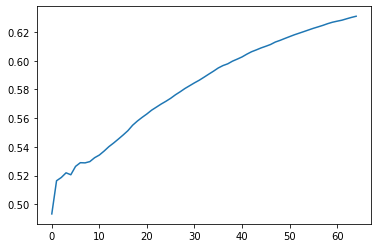

In [23]:
plt.plot(history.history['auc'])

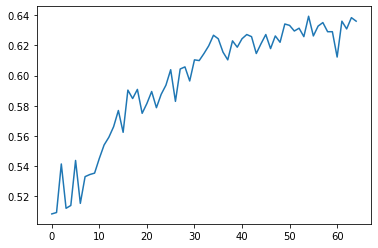

In [24]:
plt.plot(history.history['binary_accuracy'])

In [24]:
def get_best_thresholds_precision(valY, pred_Y):
    df = pd.DataFrame(columns=['threshold_type', 'threshold_value', 'precision', 'recall', 'f1'])
    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
    for i in np.arange(0,1,.2):
        precision_value = i
        idx = (np.abs(precision - precision_value)).argmin()
        data_dict = {
            'threshold_type': 'precision',
            'threshold_value': i,
            'precision': precision[idx],
            'recall': recall[idx],
            'f1': calc_f1(precision[idx],recall[idx]),
        }
        df = df.append(data_dict, ignore_index=True)
    return df

In [25]:
def get_best_thresholds_recall(valY, pred_Y):
    df = pd.DataFrame(columns=['threshold_type', 'threshold_value', 'precision', 'recall', 'f1'])
    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
    for i in np.arange(0,1,.2):
        recall_value = i
        idx = (np.abs(recall - recall_value)).argmin()
        data_dict = {
            'threshold_type': 'recall',
            'threshold_value': i,
            'precision': precision[idx],
            'recall': recall[idx],
            'f1': calc_f1(precision[idx],recall[idx]),
        }
        df = df.append(data_dict, ignore_index=True)
    return df

In [26]:
precision_df = get_best_thresholds_precision(valY, pred_Y)
recall_df = get_best_thresholds_recall(valY, pred_Y)
thresh_df = precision_df.append(recall_df)
thresh_df

,threshold_type,threshold_value,precision,recall,f1
0,precision,0.0,0.75,0.857143,0.800000
1,precision,0.2,0.75,0.857143,0.800000
2,precision,0.4,0.75,0.857143,0.800000
3,precision,0.6,0.75,0.857143,0.800000
4,precision,0.8,0.80,0.571429,0.666667
0,recall,0.0,1.00,0.000000,0.000000
1,recall,0.2,1.00,0.142857,0.250000
2,recall,0.4,1.00,0.428571,0.600000
3,recall,0.6,0.80,0.571429,0.666667
4,recall,0.8,0.75,0.857143,0.800000


![](file:///C:/Users/maken/Downloads/2020-06-16%2010_24_03-Window.png)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

![](https://miro.medium.com/max/1400/1*pOtBHai4jFd-ujaNXPilRg.png)

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/3607c634303f2fd8b69ca4f9d97a491c45083cc5)

## Using precision threshold of 0.6 yielded a precision of .75, a recall of .86, and an f1 score of .80. This will be used as my threshold since it has the highest f1 score of all the attempts as well as the highest recall.

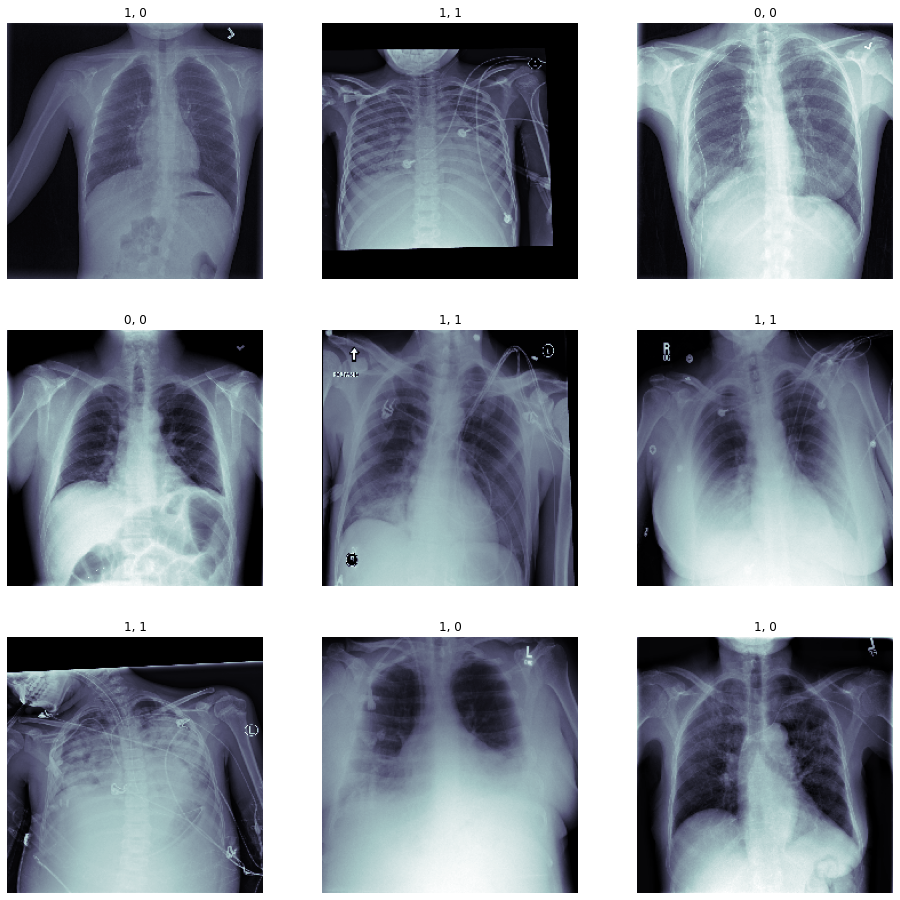

In [30]:
## Let's look at some examples of true vs. predicted with our best model: 

threshold_type = 'precision'
threshold = 0.6

fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [31]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)